1. Encoding:
    - Encode train.csv as paragraph vectors, make sure they are shuffled, take half of the paragraph vectors as 'model'. Other half is 'training'. 
    - Encode test.csv as paragraph vectors, call them 'testing'.
2. Training:
    - For each training vector, compute similarity vector, which is random_projector(training similarity with all model vectors). 
    - Train SVM to classify training vector class based on its similarity vector.
3. Inference:
    - For each testing vector, compute similarity vector just like in training, and use trained SVM to predict the class.

In [2]:
import torch
from sentence_transformers import SentenceTransformer
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
encoder = SentenceTransformer('all-MiniLM-L6-v2', device=device)
print("Encoder is loaded on:", encoder.device)

/Users/bensmus/Desktop/Projects/AG_news_classify/myenv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/Users/bensmus/Desktop/Projects/AG_news_classify/myenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Encoder is loaded on: mps:0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.svm import SVC

In [48]:
# Expect 5 mins to execute cell.

def get_model_and_training():
    filename = 'AG_news_dataset/train.csv'
    df = pd.read_csv(filename)
    descriptions, categories = shuffle(np.array(df['Description']), np.array(df['Class Index']) - 1)
    embeddings = encoder.encode(descriptions)
    model, training = np.array_split(embeddings, (10_000,))
    model_categories, training_categories = np.array_split(categories, (10_000,))
    return model, model_categories, training, training_categories

model, model_categories, training, training_categories = get_model_and_training()

In [58]:
def get_testing():
    filename = 'AG_news_dataset/test.csv'
    df = pd.read_csv(filename)
    descriptions, categories = np.array(df['Description']), np.array(df['Class Index']) - 1
    embeddings = encoder.encode(descriptions)
    return embeddings, categories

testing, testing_categories = get_testing()

In [56]:
train_similarities = encoder.similarity(training, model)

For each similarity in similarities, generate scores [cat1, cat2, cat3, cat4] where each is a weighted sum.
So have 110_000 x 4 array.

In [60]:
train_similarities_by_category = np.zeros((110_000, 4))

# Unoptimized, slow.
# for train_id, similarity in enumerate(train_similarities):
#     for model_id, weight in enumerate(similarity):
#         model_category = model_categories[model_id]
#         train_similarities_by_category[train_id][model_category] += weight

# Optimized, faster. Expect 2 minutes to execute cell.
train_similarities_1d = train_similarities.ravel()
rows = np.repeat(np.arange(110_000), 10_000) # np.repeat(np.arange(3), 2) ---> array([0, 0, 1, 1, 2, 2])
cols = np.tile(model_categories, 110_000) # np.tile(np.array([5, 6, 7], 2)) ---> array([5, 6, 7, 5, 6, 7])
np.add.at(train_similarities_by_category, (rows, cols), train_similarities_1d) # In-place modification of first argument.

Plot pair plots of train_similarities_by_category (which is an 110_000 x 4 array)

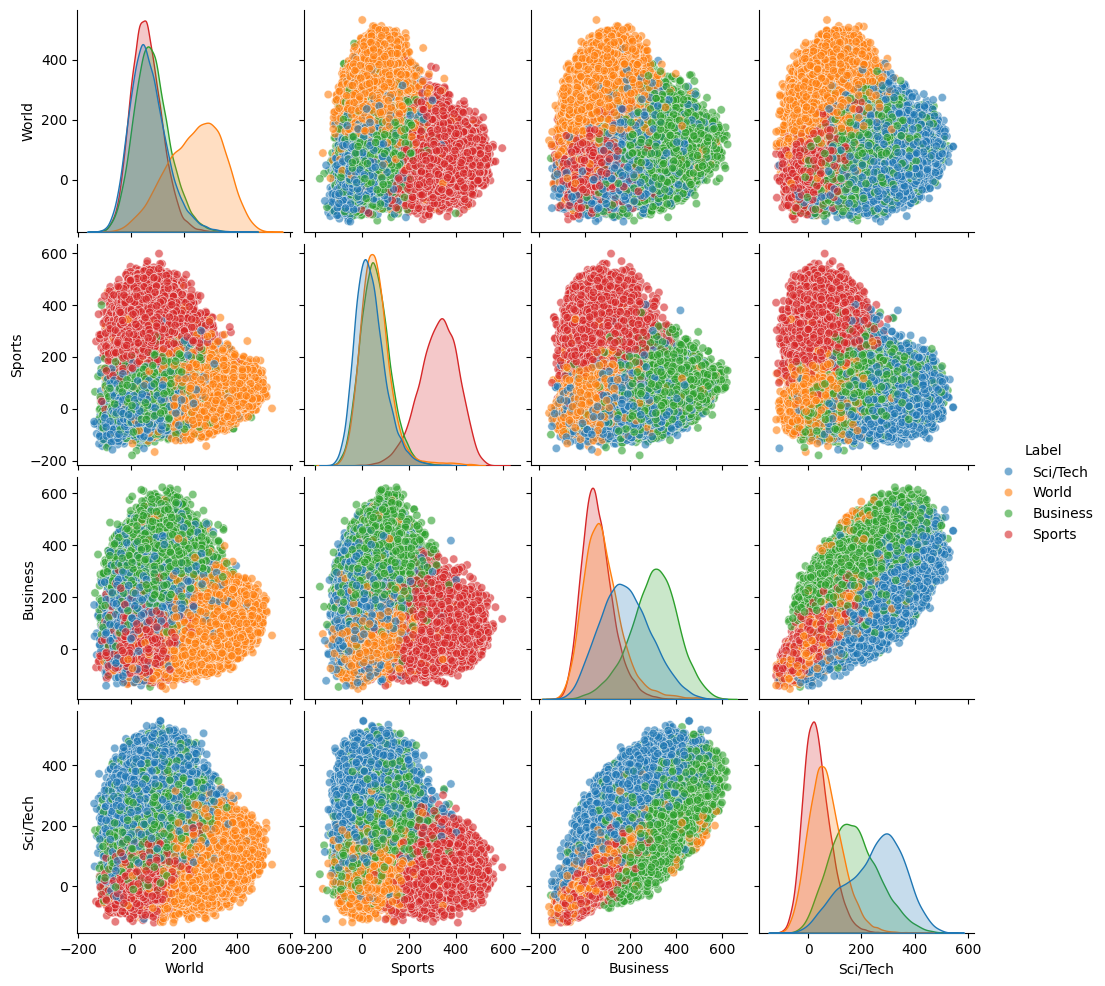

In [75]:
# Expect 1 minute to execute cell.

import seaborn as sns
category_names = np.array(['World', 'Sports', 'Business', 'Sci/Tech'])
df = pd.DataFrame(data=train_similarities_by_category, columns=category_names)
df['Label'] = category_names[training_categories]
sns.pairplot(df, hue='Label', plot_kws = {'alpha': 0.6}) 

In [61]:
# Expect 1 minute to execute cell.

classifier = SVC()
classifier.fit(train_similarities_by_category, training_categories)

SVC()

In [63]:
def inference(testing):
    """
    Args:
        testing: 2D Nx384 numpy array of paragraph vectors
    Returns:
        Size N array of class predictions
    """

    test_similarities_by_category = np.zeros((7_600, 4))
    test_similarities = encoder.similarity(testing, model)
    test_similarities_1d = test_similarities.ravel()
    rows = np.repeat(np.arange(7_600), 10_000)
    cols = np.tile(model_categories, 7_600)
    np.add.at(test_similarities_by_category, (rows, cols), test_similarities_1d)
    return classifier.predict(test_similarities_by_category)

testing_categories_predicted = inference(testing)

In [64]:
sum(testing_categories == testing_categories_predicted) / len(testing_categories)

0.86